#### Mean Reversion From Bryan Chen

This project follows closely to the article by Bryan Chen on Mean Reversion
[Website link to Bryan Chens Article](https://www.linkedin.com/pulse/algorithmic-trading-mean-reversion-using-python-bryan-chen/)

In [150]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

In [151]:
df = yf.download('AUDCAD=X', start='2015-01-01')

[*********************100%%**********************]  1 of 1 completed


In [152]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,0.94816,0.948160,0.948160,0.94816,0.94816,0
2015-01-02,0.95010,0.952200,0.945500,0.94981,0.94981,0
2015-01-05,0.95150,0.954510,0.949100,0.95110,0.95110,0
2015-01-06,0.95173,0.958270,0.950700,0.95190,0.95190,0
2015-01-07,0.95610,0.958200,0.951100,0.95620,0.95620,0
...,...,...,...,...,...,...
2024-12-27,0.89664,0.896919,0.893710,0.89664,0.89664,0
2024-12-30,0.89655,0.899090,0.893440,0.89655,0.89655,0
2024-12-31,0.89230,0.894150,0.889900,0.89230,0.89230,0


In [153]:
df['ma_20'] = df.Close.rolling(20).mean() #simple moving average 20 day
df['vol'] = df.Close.rolling(20).std() #rolling standard deviation
df['upper_bol'] = df.ma_20 + (2 * df.vol) #upper bolinger band
df['lower_bol'] = df.ma_20 - (2 * df.vol) #lower bolinger band

<AxesSubplot:xlabel='Date'>

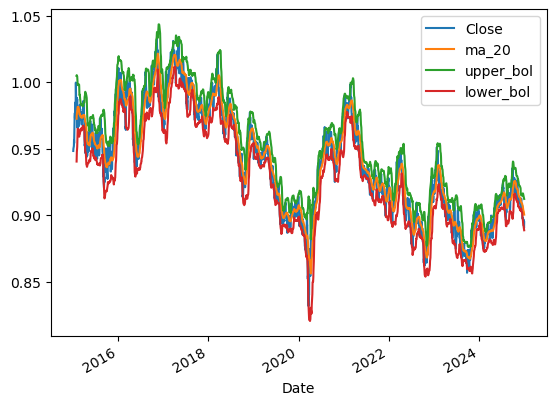

In [154]:
df[['Close', 'ma_20', 'upper_bol', 'lower_bol']].plot()

In [155]:
df['rsi'] = ta.momentum.rsi(df.Close, window = 6) #rsi indicator

In [156]:
#Conditions for buys and sells
conditions = [(df.rsi < 30) & (df.Close < df.lower_bol),
              (df.rsi > 70) & (df.Close > df.upper_bol)] 

In [157]:
choices = ['BUY', 'SELL']

In [158]:
df['signal'] = np.select(conditions, choices)

In [159]:
df.dropna(inplace=True)

In [160]:
#Shift signal row, because when we get the signal we buy on the next day
df.signal = df.signal.shift()

In [161]:
position = False
buydates, selldates = [], []
buyprices, sellprices = [], []

#loop through data
for index, row in df.iterrows():
    if not position and row['signal'] == 'BUY': #Buy when not in position
        buydates.append(index)
        buyprices.append(row.Open)
        position = True

    if position and row['signal'] == 'SELL':
        selldates.append(index)
        sellprices.append(row.Open)
        position = False

        

In [162]:
buydates, selldates, buyprices, sellprices

([Timestamp('2015-04-03 00:00:00'),
  Timestamp('2015-09-02 00:00:00'),
  Timestamp('2016-01-12 00:00:00'),
  Timestamp('2016-11-18 00:00:00'),
  Timestamp('2017-04-11 00:00:00'),
  Timestamp('2017-06-05 00:00:00'),
  Timestamp('2017-07-06 00:00:00'),
  Timestamp('2018-05-02 00:00:00'),
  Timestamp('2018-07-02 00:00:00'),
  Timestamp('2019-01-04 00:00:00'),
  Timestamp('2019-05-20 00:00:00'),
  Timestamp('2019-10-03 00:00:00'),
  Timestamp('2020-01-09 00:00:00'),
  Timestamp('2020-03-17 00:00:00'),
  Timestamp('2020-09-25 00:00:00'),
  Timestamp('2021-03-10 00:00:00'),
  Timestamp('2021-05-04 00:00:00'),
  Timestamp('2021-10-01 00:00:00'),
  Timestamp('2021-12-07 00:00:00'),
  Timestamp('2022-01-11 00:00:00'),
  Timestamp('2022-04-20 00:00:00'),
  Timestamp('2022-09-08 00:00:00'),
  Timestamp('2023-03-09 00:00:00'),
  Timestamp('2023-08-04 00:00:00'),
  Timestamp('2024-01-18 00:00:00'),
  Timestamp('2024-04-01 00:00:00'),
  Timestamp('2024-07-29 00:00:00'),
  Timestamp('2024-12-09 00:0

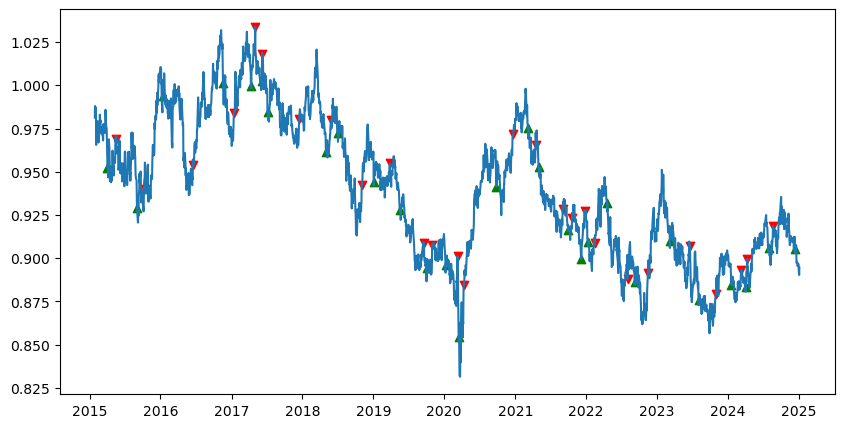

In [163]:
plt.figure(figsize= [10, 5])
plt.plot(df.Close)
plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker = '^', c = 'g') #plots green flags for buys
plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker = 'v', c = 'r') #plots red flags for sells

In [164]:
(pd.Series([(sell - buy) / buy for sell, buy in zip(sellprices, buyprices)]) + 1).prod() #This shows returns of the strategy

1.089029577699131

Include stop losses to improve strategy by risk management

In [165]:
df['shifted_close'] = df.Close.shift()

In [166]:
position = False
buydates, selldates = [], []
buyprices, sellprices = [], []

#loop through data
for index, row in df.iterrows():
    if not position and row['signal'] == 'BUY': #Buy when not in position
        buydates.append(index)
        buyprices.append(row.Open)
        position = True

    if position:
        if row['signal'] == 'SELL' or row.shifted_close < 0.95 * buyprices[-1]:
            selldates.append(index)
            sellprices.append(row.Open)
            position = False


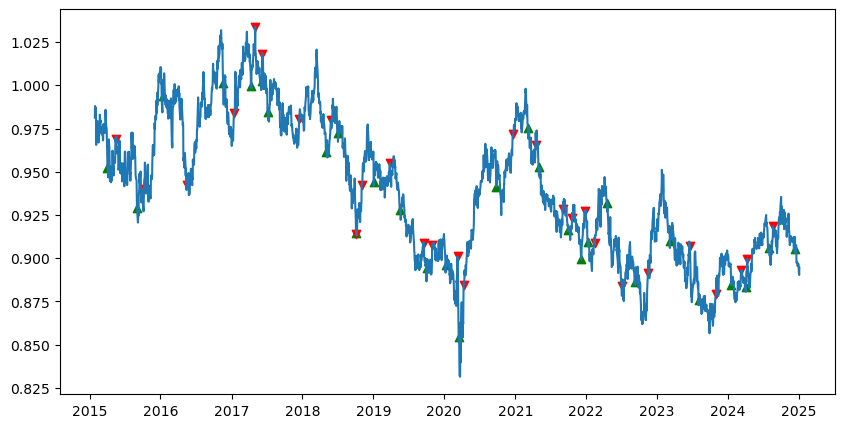

In [167]:
plt.figure(figsize= [10, 5])
plt.plot(df.Close)
plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker = '^', c = 'g') #plots green flags for buys
plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker = 'v', c = 'r') #plots red flags for sells

In [168]:
(pd.Series([(sell - buy) / buy for sell, buy in zip(sellprices, buyprices)]) + 1).prod() #This shows returns of the strategy

1.0688024638291407